In [ ]:
# First some dependencies need to be installed
!pip install tiktoken
!pip install transformers
!pip install datasets
!pip install tqdm
!pip install torch
!pip install matplotlib
!pip install termcolor
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TinyStories Dataset

Divide data into two parts:
- 90% Training
- 10% Validation

In [4]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
enc.encode("<|endoftext|>", allowed_special="all")

[50256]

In [5]:
import os
import requests
import tiktoken
import numpy as np

# Free up memory
valid_data = None
train_data = None
train_ids = None
val_ids = None

# Download and Load
def downloadx(input_file_path, data_url):
    if not os.path.exists(input_file_path) and False:
        response = requests.get(data_url)
        with open(input_file_path, 'w', encoding='utf-8') as f:
            f.write(response)
        return response

def download(input_file_path, x):
    print(f"Loading: {input_file_path}...")
    with open(input_file_path, 'r') as f:
        data = f.read()
        return data

# Load data
train_data = download('data/TinyStoriesV2-GPT4-train.txt','')
valid_data = download('data/TinyStoriesV2-GPT4-valid.txt','')

# Encode with tiktoken gpt2
enc = tiktoken.get_encoding("gpt2")
print("Encoding training data...")
train_ids = enc.encode(train_data, allowed_special="all")
print("Encoding validation data...")
val_ids = enc.encode(valid_data, allowed_special="all")
print()
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# Export to bin files for training
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile('data/story-train.bin')
val_ids.tofile('data/story-val.bin')

Loading: data/TinyStoriesV2-GPT4-train.txt...
Loading: data/TinyStoriesV2-GPT4-valid.txt...
Encoding training data..
Encoding validation data..

train has 547,725,817 tokens
val has 5,532,654 tokens


In [11]:
print(len(train_ids))
train_ids[:190]

547725817


array([  198,  7454,  2402,   257,   640,   612,   373,   257,  1310,
        2933,  3706,  3932,    13,  3932,  6151,   284,  7301,   262,
         995,  1088,   683,    13,   679,  2497,   867,  4998,  1243,
          11,   588,  4950,   410,  1386,   326,   547,   319,  3359,
         287,   257,  3650,    13,  1881,  1110,    11,  3932,   373,
        6155,   832,   262,  3650,   618,   339,  1625,  1973,   257,
         845,  2041,   410,   589,    13,  1649,  3932,  2497,   340,
         339,   373, 24562,     0,   220,   220,   198,  1544,   531,
          11,   564,   250, 22017,    11,   326,   318,   257,  1107,
        4998,   410,   589,     0,  1680,   314,  2822,   340,    30,
         447,   251,   220,   198,   464,  6128, 13884, 13541,   290,
         531,    11,   564,   250,  5189,  1781,   345,   460,    13,
         921,   460,  1011,   340,  1363,   290,   905,   477,   534,
        2460,   703,  4998,   340,   318,     0,   447,   251,   198,
        2396,  3932,

In [10]:
print(enc.decode(train_ids[:190]))


Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!
<|endoftext|>


# GPT Model Class

We will use the `model.py` file contains a GPT model class that was created by Andrej Karpathy. It was modeled after the one created by OpenAI.

* Attention Is All You Need - https://arxiv.org/pdf/1706.03762
* OpenAI GPT-2 - https://github.com/openai/gpt-2/blob/master/src/model.py
* nanoGPT - https://github.com/karpathy/nanoGPT


# Train a Model

In [12]:
max_iters = 5000 # total number of training iterations
checkpoint_file = f'zstory{max_iters}.pt'

import os
import time
import math
from contextlib import nullcontext

import numpy as np
import torch
from model import GPTConfig, GPT

################################# Parameters ##################################
"""
GPT-2 Settings
    block_size: int = 1024
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
"""

# config
eval_iters = 200 # number of iterations to run evaluation
dataset = 'data' # directory where the data is stored
gradient_accumulation_steps = 5 * 8 # used to simulate larger batch sizes
batch_size = 12 # [12] number of batches to run in parallel
block_size = 1024 # [32] content window size (tokens)

# model
n_layer = 12     # 4  - layers of 
n_head = 12      # 4  - attention heads
n_embd = 768     # 64 - dimensionality of the embedding vectors
dropout = 0.2   # 0. - for pretraining 0 is good, for finetuning try 0.1+
bias = False    # False - do we use bias inside LayerNorm and Linear layers?

# adamw optimizer
learning_rate = 6e-4 # 6e-4 max learning rate
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0

# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 60000 # [600000] should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla

# system
device = 'cuda' # examples: 'cpu', 'cuda', or try 'mps' on macbooks
dtype = 'bfloat16' # 'float32', 'bfloat16', or 'float16'

###############################################################################

# capture above settings & parameters to save in model checkpoint
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} 

# tokens per iterations
tokens_per_iter = gradient_accumulation_steps * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

# set the random seed
seed = 1337
torch.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# Load the data
data_dir = dataset + '/'
train_data = np.memmap(os.path.join(data_dir, 'story-train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'story-val.bin'), dtype=np.uint16, mode='r')

# get a batch from the data
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# loop counters starting point
iter_num = 0

# init a new model from scratch
print("Initializing a new model from scratch")
print("Using vocab_size of GPT-2 of 50304 (50257 rounded up for efficiency)")
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=50304, dropout=dropout) 
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)

# report number of parameters
print("Number of parameters: %.2fM" % (model.get_num_params()/1e6,))
print("Layers:")
for number, (name, param) in enumerate(model.named_parameters()):
    print(number, name)

# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler
#scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
scaler = torch.amp.GradScaler(device_type, enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

# compile the model if not using MPS
if device == 'mps':
    print("MPS doesn't support JIT compilation, skipping...")
else:
    print("compiling the model... (takes a ~minute)")
    model = torch.compile(model) # requires PyTorch 2.0

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad() # disable gradient tracking - not needed for backward pass
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# save model to checkpoint file
def save_model(fn):
    checkpoint = {
        'model': raw_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model_args': model_args,
        'iter_num': iter_num,
        'config': config,
    }
    print(f"saving checkpoint to {fn}")
    torch.save(checkpoint, fn)

# stats
stat_iter = []
stat_loss_train = []
stat_loss_val = []
stat_lr_iter = []
stat_lr = []

# TRAINING LOOP

# init loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model
running_mfu = -1.0 # Memory Footprint Utilization on GPU

while True:
    try:
        # determine and set the learning rate for this iteration
        lr = get_lr(iter_num) if decay_lr else learning_rate
        if lr > 0:
            stat_lr.append(lr)
            stat_lr_iter.append(iter_num)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # evaluate the loss on train/val sets and write checkpoints
        if iter_num % 100 == 0 or iter_num >= max_iters:
            losses = estimate_loss()
            print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            if iter_num > 0:
                save_model(checkpoint_file)
            # record stats
            stat_iter.append(iter_num)
            stat_loss_train.append(losses['train'])
            stat_loss_val.append(losses['val'])
    
        # FORWARD PROP, update with optional gradient accumulation to simulate larger batch size
        # and using the GradScaler if data type is float16
        for micro_step in range(gradient_accumulation_steps):
            with ctx:
                logits, loss = model(X, Y)
                loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
            # immediately async prefetch next batch while model is doing the forward pass on the GPU
            X, Y = get_batch('train')
            # with gradient scaling if training in fp16
            scaler.scale(loss).backward()
        # clip the gradient - to avoid exploding gradients
        if grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        # BACK PROP
        # step the optimizer and scaler if training in fp16
        scaler.step(optimizer)
        scaler.update()
        # flush the gradients as soon as we can, no need for this memory anymore
        optimizer.zero_grad(set_to_none=True)
    
        # stats for timing
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        if iter_num % 10 == 0:
            print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
        iter_num += 1
        local_iter_num += 1
    
        # termination conditions
        if iter_num > max_iters:
            break

    except KeyboardInterrupt:
        print("User requested exit, saving checkpoint")
        break

save_model(checkpoint_file)

tokens per iteration will be: 491,520
Initializing a new model from scratch
Using vocab_size of GPT-2 of 50304 (50257 rounded up for efficiency)
Number of parameters: 123.59M
Layers:
0 transformer.wte.weight
1 transformer.wpe.weight
2 transformer.h.0.ln_1.weight
3 transformer.h.0.attn.c_attn.weight
4 transformer.h.0.attn.c_proj.weight
5 transformer.h.0.ln_2.weight
6 transformer.h.0.mlp.c_fc.weight
7 transformer.h.0.mlp.c_proj.weight
8 transformer.h.1.ln_1.weight
9 transformer.h.1.attn.c_attn.weight
10 transformer.h.1.attn.c_proj.weight
11 transformer.h.1.ln_2.weight
12 transformer.h.1.mlp.c_fc.weight
13 transformer.h.1.mlp.c_proj.weight
14 transformer.h.2.ln_1.weight
15 transformer.h.2.attn.c_attn.weight
16 transformer.h.2.attn.c_proj.weight
17 transformer.h.2.ln_2.weight
18 transformer.h.2.mlp.c_fc.weight
19 transformer.h.2.mlp.c_proj.weight
20 transformer.h.3.ln_1.weight
21 transformer.h.3.attn.c_attn.weight
22 transformer.h.3.attn.c_proj.weight
23 transformer.h.3.ln_2.weight
24 tran

losses['train']=tensor(1.0397) losses['val']=tensor(1.0572)


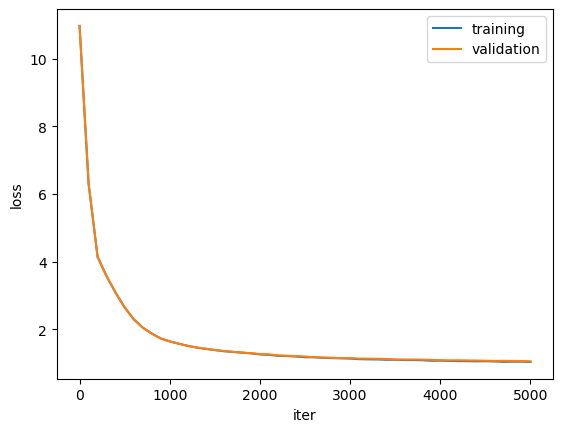

In [13]:
# Graph
import matplotlib.pyplot as plt
%matplotlib inline
print(f"{losses['train']=} {losses['val']=}")
plt.plot(stat_iter, stat_loss_train, stat_iter, stat_loss_val)
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend(['training', 'validation'])

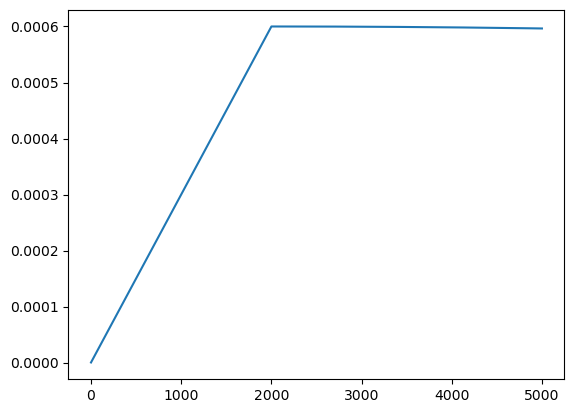

In [19]:
plt.plot(stat_lr_iter, stat_lr)

# Inference

In [21]:
#checkpoint_file = 'xmodel5000-story.pt'

from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

print(f"Checkpoint: {checkpoint_file}")

# inference parameters
max_tokens = 500 # number of tokens generated in each sample
temperature = 1.0 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 42
device = 'cuda'
dtype = 'bfloat16'

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# load model saved in a specific directory
checkpoint = torch.load(checkpoint_file, map_location=device, weights_only=True)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
enc = tiktoken.get_encoding("gpt2")
print("Number of parameters: %.2fM" % (model.get_num_params()/1e6,))

# set prompt
prompt = "Once upon a time, there was a rabbit"
start_ids = enc.encode(prompt, allowed_special={"<|endoftext|>"})
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        y = model.generate(x, max_tokens, temperature=temperature, top_k=top_k)
        output = y[0].tolist()
        for w in output:
            if w > 50257: # max token value, ignore the rest
                continue
            elif w == enc.eot_token: # stop at end of story
                print("--- The End ---")
                break
            else:
                text = enc.decode([w])
                if text == '\n':
                    print()
                else:
                    print(text, end='')
                
print("")


Checkpoint: zstory5000.pt
Number of parameters: 123.59M
Once upon a time, there was a rabbit named Bob. He lived in a comfortable home in the woods. One day, Bob felt sad because he could not find his friends.
Bob wondered where his friends were. He hopped around the woods, asking flowers and trees if they had seen them. Finally, he found his friends playing near the river. They were all laughing and having fun.
Bob was so happy to see his friends again. He felt happy that his search led him where they were. From that day on, Bob and his friends always made sure to play together and help each other whenever they could.
--- The End ---



## References

* Standford Univesity - CS231n: Deep Learning for Computer Vision - https://cs231n.github.io/neural-networks-1/
* Visual Transformer, Explained - https://poloclub.github.io/transformer-explainer/
* Cousera: Generative Ai with LLMs - https://www.coursera.org/learn/generative-ai-with-llms
* Attention is All You Need by Vaswani et al. in 2017 - https://arxiv.org/abs/1706.03762
* The Illustrated Transformer by Jay Alammar - https://jalammar.github.io/illustrated-transformer/
* Visualizing Attention, a Transformer's Heart - https://www.3blue1brown.com/lessons/attention
* Let's build GPT: from scratch, in code, spelled out. - by Andrej Karpathy - https://www.youtube.com/watch?v=kCc8FmEb1nY
* nanoGPT by Andrej Karpathy - https://github.com/karpathy/nanoGPT
* OpenAI GPT-2 - https://github.com/openai/gpt-2/blob/master/src/model.py

## Papers
- Makemore, by Andrej Karpathy - https://github.com/karpathy/makemore
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)